In [11]:
import  os, sys
import  matplotlib.pyplot as plt
import yaml
import numpy as np

sys.path.append('../')  # Add parent dir to path

import hardware

In [12]:
import pandas as pd

In [13]:
config = yaml.safe_load(open('../config/devices.yml','r'))
config = config['battery']
config['initial']=config['capacity']*0.95 # start with full 
print(config)

{'initial': 228.9405, 'capacity': 240.99, 'charge_unit': 'Ah', 'capacity_fade': 0.0063, 'self_discharge': 0.01, 'VOC_table': 'data/hardware/battery/battery_VOC.dat', 'VOC_table_cols': 'SOC VOC@0 R@0 VOC@20 R@20 VOC@40 R@40'}


In [14]:
ryan_pvt = pd.read_csv('ColdNight1_PowerVsTime.csv',delimiter=',', header= None)
ryan_pvt= ryan_pvt.T
ryan_pvt.columns = ryan_pvt.iloc[0]
ryan_pvt = ryan_pvt.drop(0)
ryan_pvt['Summed_all'] = ryan_pvt['PMU Q_SUM'].astype(float)+ryan_pvt['PFPS_Q_SUM'].astype(float)+ryan_pvt['PDU_Q_SUM'].astype(float)+ryan_pvt['DCB_Q_SUM'].astype(float)+ryan_pvt['Spectrometer_Q_SUM'].astype(float)+ryan_pvt['Pre-Amp 1 Q_SUM'].astype(float)+ryan_pvt['Pre-Amp 2 Q_SUM'].astype(float)+ryan_pvt['Pre-Amp 3 Q_SUM'].astype(float) +ryan_pvt['Pre-Amp 4 Q_SUM'].astype(float)+ryan_pvt['Radio_SUM'].astype(float)
time_ryan = ryan_pvt['Nodes/Times'].iloc[:, 0] 
#print(ryan_pvt['Summed_all'][2310:2362])

In [15]:
#print(time_ryan[0:2362])
time_ryan = time_ryan[0:2362]

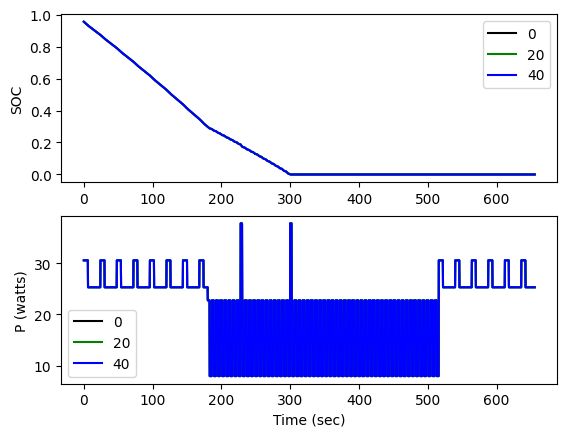

In [22]:
colors = ['k','g','b']
temperatures = [0, 20, 40]
plt.figure()

for j,T in enumerate(temperatures): ## we need this from Ryan
    B = hardware.Battery(config, verbose=False)
    B.set_temperature(T)
    energy = 0
    deltaT_list= []
    soc_values = []
    power_values = []
    
    #while (B.SOC()>0.05):
    for i in range(len(time_ryan) - 1):
        deltaT =  3600*(time_ryan.iloc[i+1] -time_ryan.iloc[i])
        #print(deltaT, deltaP)
        deltaT_list.append(deltaT)
        P =ryan_pvt['Summed_all'].iloc[i]
        power_values.append(P)
        B.apply_power(-P,deltaT) # discharge at 1W
        energy += deltaT*P
        soc_values.append(B.SOC())
    #if B.SOC() <= 0.05:
       # break
    plt.subplot(2, 1, 1)
    plt.plot(time_ryan[:-1], soc_values, color = colors[j],label=T)
    plt.legend()
    plt.ylabel('SOC')
    plt.subplot(2, 1, 2)
    plt.plot(time_ryan[:-1],power_values, color = colors[j],label=T )
    plt.ylabel('P (watts)')
    plt.legend()

plt.xlabel('Time (sec)')

plt.show() 

